In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def resumen(datos):
    return print('Forma:\n', datos.shape,'\n\n',
                 'Columnas:\n', datos.columns,'\n\n',
                 'Tipos:\n', datos.dtypes,'\n\n',
                 'Datos nulos:\n', datos.isnull().sum(),'\n\n',
                 'Cabecera:\n', datos.head(10),'\n\n',
                 'Últimos datos:\n', datos.tail(10),'\n\n',
                 'Estadísticos:\n', datos.describe([0.05,0.25,0.5,0.75,0.95])
                )
def truncar(numero, decimales = 0):
    return np.trunc(numero*10**decimales)/(10**decimales)

In [3]:
def lineal(x, a, b):
    linea = a*x + b
    return linea
def respiracion_1(t, ref, t0):
    # Poner t en Kelvin
    tref = 283
    e0 = 135
    resp = ref * np.exp(e0*(1/(tref-t0)-1/(t-t0)))
    return resp
def respiracion_2(t, ref, e0):
    # Poner t en Kelvin    
    tref = 283.16
    resp = ref * np.exp(e0*(1-tref/t)*(1/tref*8.31))
    return resp
def beta(b0, k, vpd, vpd0):
    if vpd > vpd0:
        beta = b0 * np.exp(-k*(vpd-vpd0))
    else:
        beta = b0
    return beta
def gpp(alfa, beta, rg):
    gpp = (alfa*beta*rg) / (alfa*rg + beta)
    return gpp
def nee(resp, gpp):
    nee = resp + gpp
    return nee

In [4]:
def coef_determinacion(observaciones, predicciones):
    residuo = observaciones - predicciones
    ss_res = np.sum(residuo**2)
    ss_tot = np.sum((observaciones - np.mean(observaciones))**2)
    r_cuadrado = 1 - (ss_res/ss_tot)
    return r_cuadrado
def regresion(modelo, x, y):
    # No puede haber nungún NaN
    ajuste, covarianzas = curve_fit(modelo, x, y)
    predicciones = modelo(x, *ajuste)
    errores = np.sqrt(np.diag(covarianzas))
    r_cuadrado = coef_determinacion(y, predicciones)
    return predicciones, ajuste, errores, r_cuadrado

In [75]:
def metadata(ejex, ejey):
    # plt.title(titulo, fontsize = 60, fontweight='bold')
    plt.xlabel(ejex, fontsize = 35)
    plt.ylabel(ejey, fontsize = 35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    return
def cifras_signif(i, cifras):
    return str('{:g}'.format(float('{:.{p}g}'.format(i, p = cifras))))
def grafico_modelo(x, y, predicciones, ajuste, errores, r_cuad):
    plt.plot(x, y, 'bo')
    plt.plot(x, predicciones, 'r-',
             label = (' a = ' + cifras_signif(ajuste[0], 3)
                      + ' std_a = ' + cifras_signif(errores[0], 3) + '\n'
                      + ' b = ' + cifras_signif(ajuste[1], 3)
                      + ' std_b = ' + cifras_signif(errores[1], 3) + '\n'
                      + ' R^2 = ' + cifras_signif(r_cuad, 3)
                     )
             )
    plt.legend(fontsize = 20)
    return

In [51]:
def regresion_y_grafico(modelo, x, y, xlabel, ylabel):
    predicciones, ajuste, errores, r_cuadrado = regresion(modelo, x, y)
    scatter = plt.figure(figsize = (18, 9))
    metadata(xlabel, ylabel)
    grafico_modelo(x, y, predicciones, ajuste, errores, r_cuadrado)
    return scatter, ajuste
def identidad(metodo, ajuste, validacion_x, validacion_y, lab):
    iterador = list(validacion_x.index)
    pred = list(range(len(validacion_x)))
    for i in iterador:
        j = iterador.index(i)
        pred[j] = metodo(validacion_x[i], ajuste[0], ajuste[1])
    comparacion, a = regresion_y_grafico(lineal,
                                         validacion_y,
                                         pred,
                                         lab + ' Obs',
                                         lab + ' Pred'
                                         )
    extremos = [validacion_y.min(), validacion_y.max()]
    plt.plot(extremos, extremos, 'g--')
    return comparacion, pred

In [76]:
def mbe(x, y):
    n = x.count()
    diff = y - x
    mbe = diff.sum() * (1/n)
    return mbe
def mae(x, y):
    n = x.count()
    diff = abs(y - x)
    mae = diff.sum() * (1/n)
    return mae
def mse(x, y):
    n = x.count()
    diff = (y - x)**2
    mse = diff.sum() * (1/n)
    return mse
def rmse(x, y):
    rmse = (mse(x, y))**(1/2)
    return rmse
def indice_acuerdo(x, y):
    diff = (y - x)**2
    long = (np.abs(x) + np.abs(y))**2
    d = 1 - diff.sum()/long.sum()
    return d
def metricas(x, y):
    j = 3
    mbe_f = cifras_signif(mbe(x, y), j)
    mae_f = cifras_signif(mae(x, y), j)
    mse_f = cifras_signif(mse(x, y), j)
    rmse_f = cifras_signif(rmse(x, y), j)
    indice_f = cifras_signif(indice_acuerdo(x, y), j)
    return print('MBE ' + mbe_f + '\n'
                'MAE ' + mae_f + '\n'
                'MSE ' + mse_f + '\n'
                'RMSE ' + rmse_f + '\n'
                'Indice de acuerdo ' + indice_f + '\n')

In [53]:
def analisis(metodo, x, y, validacion_x, validacion_y, xlab, ylab):
    modelo, ajuste = regresion_y_grafico(metodo,
                                         x,
                                         y,
                                         xlab,
                                         ylab
                                         )
    ident, pred = identidad(metodo,
                            ajuste,
                            validacion_x,
                            validacion_y,
                            ylab
                            )
    metricas(validacion_y, pred)
    return modelo, ident

In [9]:
datos = pd.read_csv(
    'C:\\Users\\nahue\\Desktop\\Tesis_2\\Datos\\Para_subir.txt',
    #'C:\\Users\\BIOMET\\Desktop\\Tesis_2\\Datos\\Para_subir.txt',
    delimiter = '\t',
    decimal = '.',
    na_values = -9999,
    skiprows = [1],
    encoding = 'ascii'
    )

In [10]:
resumen(datos)

Forma:
 (14443, 12) 

 Columnas:
 Index(['Year', 'DoY', 'Hour', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil', 'rH',
       'VPD', 'Ustar'],
      dtype='object') 

 Tipos:
 Year     float64
DoY      float64
Hour     float64
NEE      float64
LE       float64
H        float64
Rg       float64
Tair     float64
Tsoil    float64
rH       float64
VPD      float64
Ustar    float64
dtype: object 

 Datos nulos:
 Year        0
DoY         0
Hour        0
NEE      6285
LE       5888
H        5043
Rg       1392
Tair     1392
Tsoil    1392
rH       1392
VPD      1392
Ustar    4472
dtype: int64 

 Cabecera:
      Year   DoY  Hour  NEE  LE   H       Rg    Tair    Tsoil      rH     VPD  \
0  2018.0  54.0   9.0  NaN NaN NaN   525.40  19.180  18.1400  59.930   8.890   
1  2018.0  54.0   9.5  NaN NaN NaN   555.25  19.290  18.1800  59.295   9.095   
2  2018.0  54.0  10.0  NaN NaN NaN   673.15  19.515  18.3700  57.470   9.635   
3  2018.0  54.0  10.5  NaN NaN NaN   833.00  19.640  19.0100  58.040   9.580   
4 

In [11]:
dias = np.array([0, 16, 46, 76,
                107, 137, 168, 199,
                229, 260, 290, 303
                ])
lista = list(range(1, len(dias)))
promedio = list(range(1, len(dias)))
for i in lista:
    desde = dias[i-1] * 48
    hasta = dias[i] * 48
    promedio[i-1] = datos['Tair'][desde:hasta].mean()
print(promedio)

[20.15856119791667, 17.011829861111117, 16.99210416666672, 10.50837042925283, 7.789507092198634, 8.451635977337133, 10.250084175084222, 13.118305555555533, 14.59001008064517, 17.031122377622424, 21.364954128440452]


In [12]:
datos['Tair'].mean()

13.522264577427045

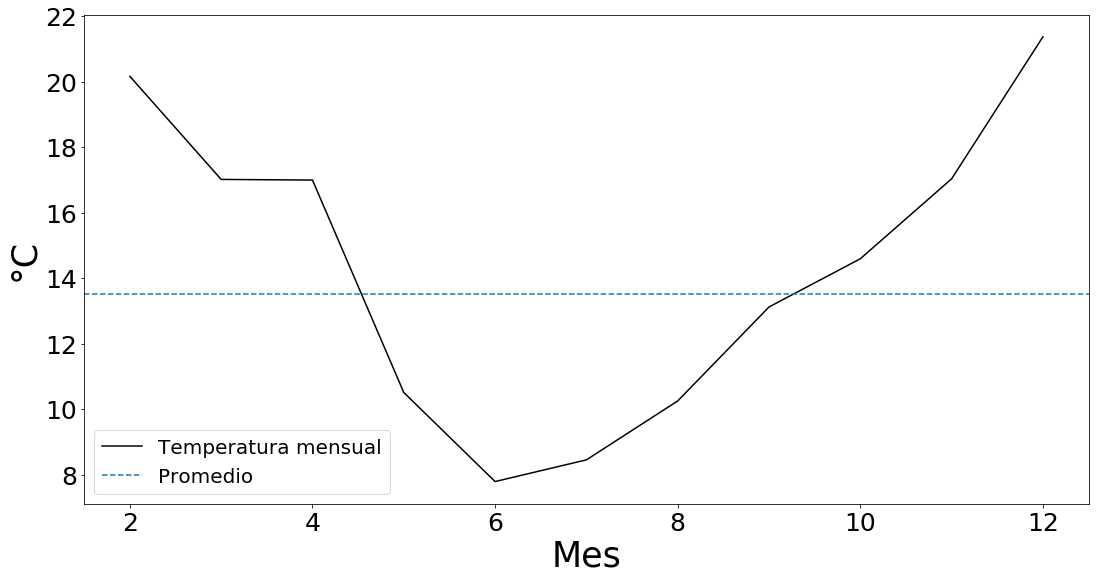

In [13]:
x = list(range(2, 13))
plt.figure(figsize = (18, 9))
plt.plot(x, promedio, color = 'black')
metadata('Mes', '°C')
plt.axhline(datos['Tair'].mean(), ls = '--')
plt.legend(['Temperatura mensual', 'Promedio'], fontsize= 20)

In [14]:
datos_validos = datos[(datos['Rg'] < 5)
                      & (datos['Ustar'] > 0.14167)
                      & pd.notna(datos['Tair'])
                      & (datos['NEE'] >= 0)
                     ]
datos_validos.describe()

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,VPD,Ustar
count,2171.0,2171.000000,2171.000000,2171.000000,2112.000000,2170.000000,2.171000e+03,2171.000000,2171.000000,2171.000000,2171.000000,2171.000000
mean,2018.0,247.984339,11.026716,1.696985,7.752176,-32.870873,1.599102e-01,11.337589,11.569908,80.331713,2.826575,0.325019
std,0.0,63.345216,9.099044,1.432462,20.188574,17.050212,6.085620e-01,4.460148,3.517135,9.493835,2.007111,0.140832
min,2018.0,91.000000,0.000000,0.000450,-205.078369,-138.818542,1.808498e-12,-1.005000,4.187500,29.065000,0.415000,0.141686
25%,2018.0,208.000000,3.000000,0.707425,-4.021991,-43.011824,2.000000e-02,8.585000,8.555000,75.117500,1.520000,0.211640
50%,2018.0,255.000000,6.000000,1.330000,4.443480,-30.677891,2.500000e-02,10.975000,11.272500,82.150000,2.380000,0.293324
75%,2018.0,298.000000,21.000000,2.262975,15.096420,-20.857051,3.000000e-02,13.935000,14.218750,87.800000,3.495000,0.418286
max,2018.0,346.000000,23.500000,14.427700,163.791779,16.905794,4.795000e+00,28.455000,21.315000,94.500000,24.715000,1.023678


In [15]:
periodo_1 = datos_validos[(datos_validos['DoY'] > 0)
                         & (datos_validos['DoY'] < 76)
                         ]
periodo_2 = datos_validos[(datos_validos['DoY'] > 76)
                         & (datos_validos['DoY'] < 168)
                         ]
periodo_3 = datos_validos[(datos_validos['DoY'] > 168)
                         & (datos_validos['DoY'] < 229)
                         ]
periodo_4 = datos_validos[(datos_validos['DoY'] > 229)
                         & (datos_validos['DoY'] < 303)
                         ]

In [16]:
periodo_1.describe()

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,VPD,Ustar
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
periodo_2.describe()

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,VPD,Ustar
count,241.0,241.000000,241.000000,241.000000,231.000000,240.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,2018.0,131.506224,11.703320,2.388246,4.969880,-29.356454,0.113548,12.599481,12.503019,81.363963,3.028568,0.349364
std,0.0,31.195502,8.964987,1.735809,24.281045,15.183756,0.501705,5.193599,3.880064,10.072877,2.151929,0.152578
min,2018.0,91.000000,0.000000,0.005450,-205.078369,-79.513046,0.010000,1.170000,6.270000,43.250000,0.415000,0.141915
25%,2018.0,96.000000,3.500000,0.840050,-6.133488,-38.048247,0.020000,9.270000,8.977500,78.965000,1.350000,0.213785
50%,2018.0,138.000000,7.500000,2.198900,2.943372,-26.161980,0.025000,11.815000,11.025000,83.850000,2.640000,0.326878
75%,2018.0,162.000000,21.000000,3.526050,13.358574,-18.815817,0.030000,17.015000,16.617500,88.850000,3.740000,0.476697
max,2018.0,167.000000,23.500000,8.714800,101.216587,-2.509075,4.470000,22.355000,18.897500,94.500000,10.780000,0.811924


In [18]:
periodo_3.describe()

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,VPD,Ustar
count,503.0,503.000000,503.000000,503.000000,483.000000,503.000000,5.030000e+02,503.000000,503.000000,503.000000,503.000000,503.000000
mean,2018.0,198.125249,11.456262,0.875389,2.890050,-31.072709,1.148907e-01,7.885030,7.883668,82.699205,1.887525,0.292826
std,0.0,19.420238,8.825730,0.649445,18.273086,15.826638,4.878226e-01,3.015131,1.503938,7.315156,0.937646,0.116482
min,2018.0,169.000000,0.000000,0.006400,-111.854263,-138.818542,1.808498e-12,-1.005000,4.187500,45.780000,0.485000,0.144029
25%,2018.0,178.000000,3.250000,0.398900,-4.537028,-40.255754,2.000000e-02,5.740000,6.933750,79.370000,1.257500,0.204095
50%,2018.0,203.000000,7.500000,0.770450,1.539482,-29.598499,2.000000e-02,8.535000,8.015000,84.350000,1.690000,0.269174
75%,2018.0,214.000000,20.500000,1.177150,6.997084,-21.467219,2.500000e-02,10.280000,8.728750,87.525000,2.287500,0.355837
max,2018.0,228.000000,23.500000,5.843000,163.791779,1.709284,4.590000e+00,13.835000,11.405000,94.350000,6.385000,1.023678


In [19]:
periodo_4.describe()

,Year,DoY,Hour,NEE,LE,H,Rg,Tair,Tsoil,rH,VPD,Ustar
count,894.0,894.000000,894.000000,894.000000,875.000000,894.000000,894.000000,894.000000,894.000000,894.000000,894.000000,894.000000
mean,2018.0,266.953020,10.666667,1.506720,6.046634,-31.921252,0.181521,10.966342,11.285271,80.314055,2.631997,0.321918
std,0.0,22.832415,9.053571,1.146595,16.009369,17.554522,0.661928,3.398901,2.312347,9.069617,1.380079,0.141629
min,2018.0,230.000000,0.000000,0.000450,-86.276268,-94.156578,0.010000,1.950000,5.822500,52.285000,0.460000,0.141686
25%,2018.0,243.000000,2.500000,0.678037,-4.906959,-42.240859,0.020000,8.648750,9.673750,74.268750,1.561250,0.211120
50%,2018.0,270.000000,6.000000,1.296075,3.304792,-28.922121,0.025000,10.962500,11.510000,81.825000,2.452500,0.278391
75%,2018.0,287.750000,21.000000,1.996225,14.448582,-19.999993,0.030000,13.023750,12.833125,88.150000,3.373750,0.417637
max,2018.0,302.000000,23.500000,7.834750,68.776390,9.088656,4.795000,23.000000,17.475000,94.350000,11.000000,0.849662


In [23]:
muestra_p2 = periodo_2.sample(frac = 4/5, random_state = 1).sort_values('Tair')
validacion_p2 = periodo_2.drop(muestra_p2.index)
muestra_p3 = periodo_3.sample(frac = 4/5, random_state = 1).sort_values('Tair')
validacion_p3 = periodo_3.drop(muestra_p3.index)
muestra_p4 = periodo_4.sample(frac = 4/5, random_state = 1).sort_values('Tair')
validacion_p4 = periodo_4.drop(muestra_p4.index)

MBE 0.056
MAE 0.973
MSE 1.52
RMSE 1.23
Indice de acuerdo 0.947



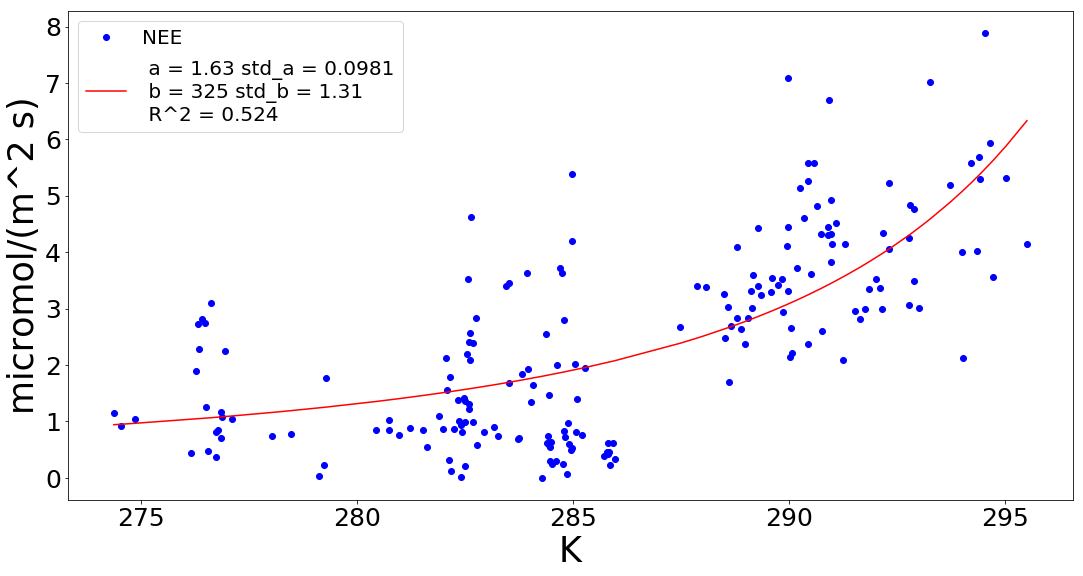

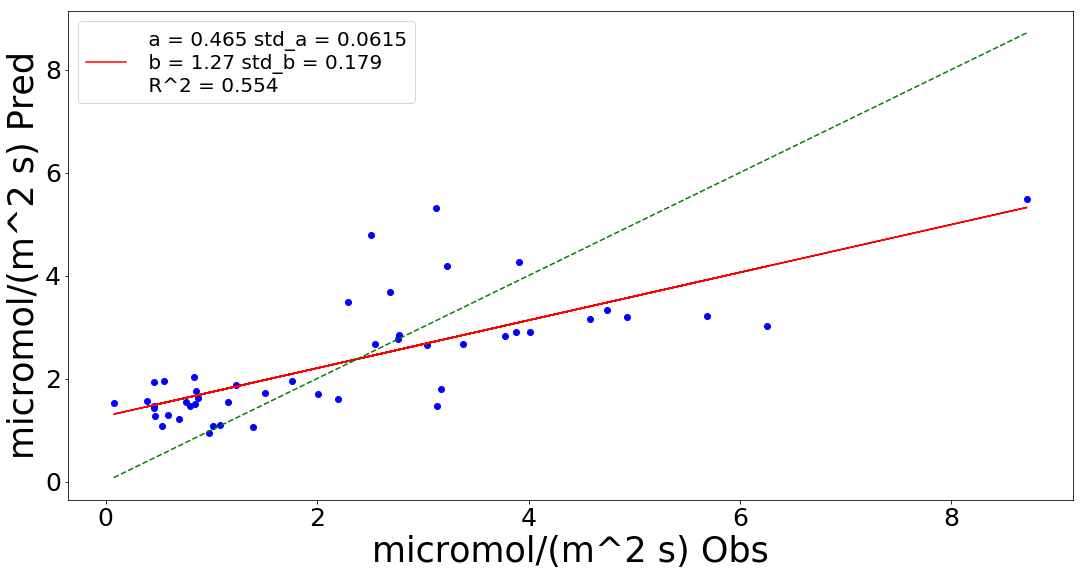

In [77]:
mod_1_p2, comp_1_p2 = analisis(respiracion_1,
                               muestra_p2['Tair'].add(273.15),
                               muestra_p2['NEE'],
                               validacion_p2['Tair'].add(273.15),
                               validacion_p2['NEE'],
                               'K', 'micromol/(m^2 s)')

MBE 0.00746
MAE 0.457
MSE 0.326
RMSE 0.571
Indice de acuerdo 0.907



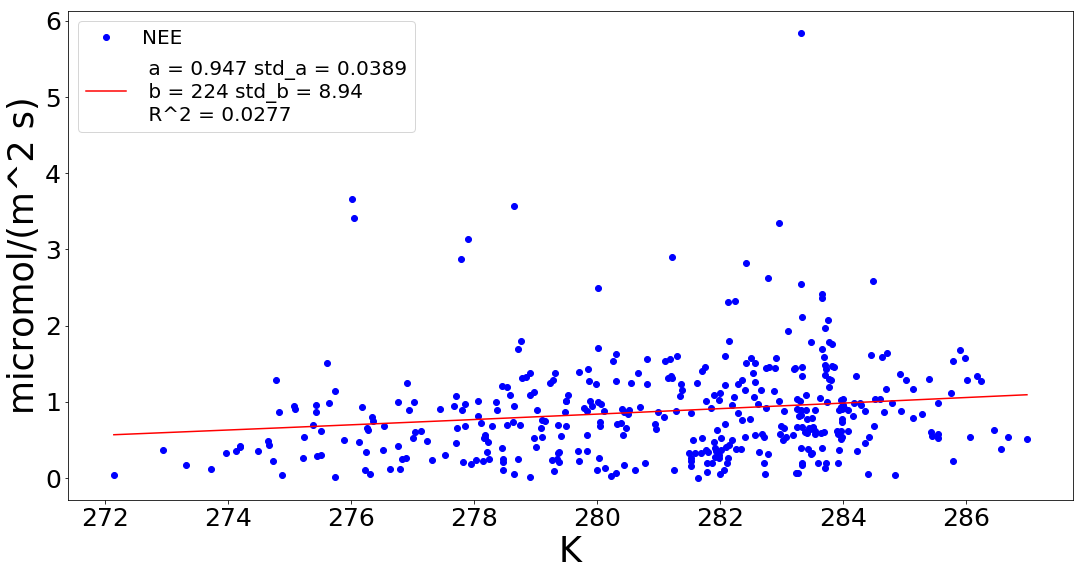

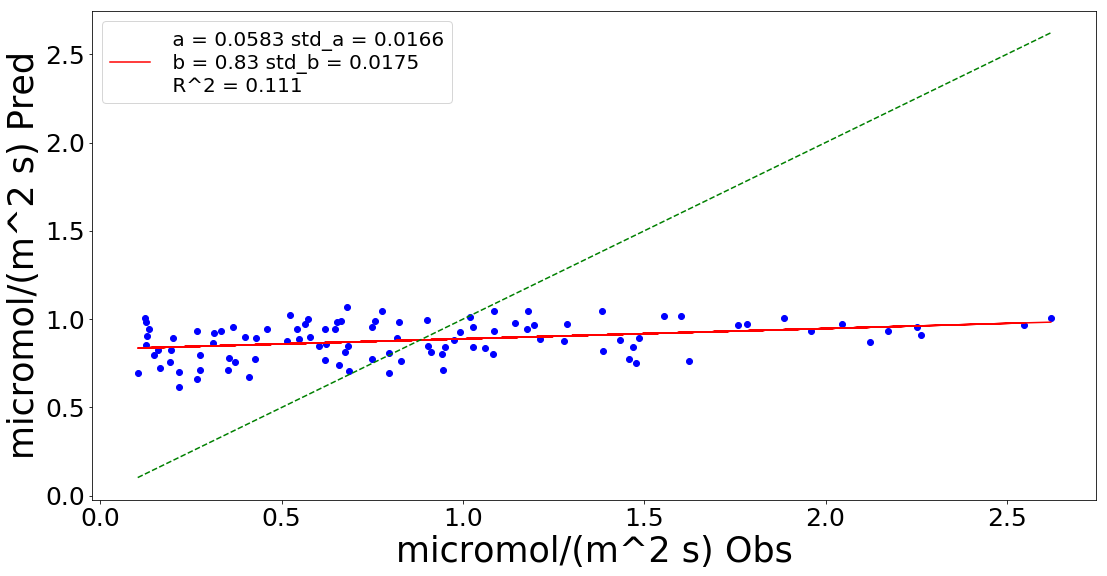

In [78]:
mod_1_p3, comp_1_p3 = analisis(respiracion_1,
                               muestra_p3['Tair'].add(273.15),
                               muestra_p3['NEE'],
                               validacion_p3['Tair'].add(273.15),
                               validacion_p3['NEE'],
                               'K', 'micromol/(m^2 s)')

MBE -0.074
MAE 0.748
MSE 1.1
RMSE 1.05
Indice de acuerdo 0.902



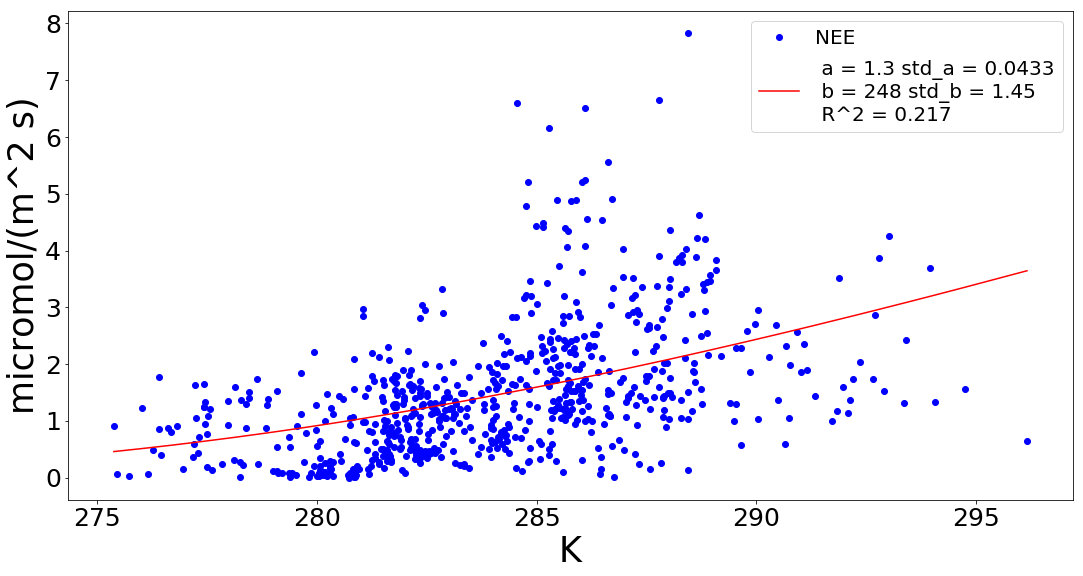

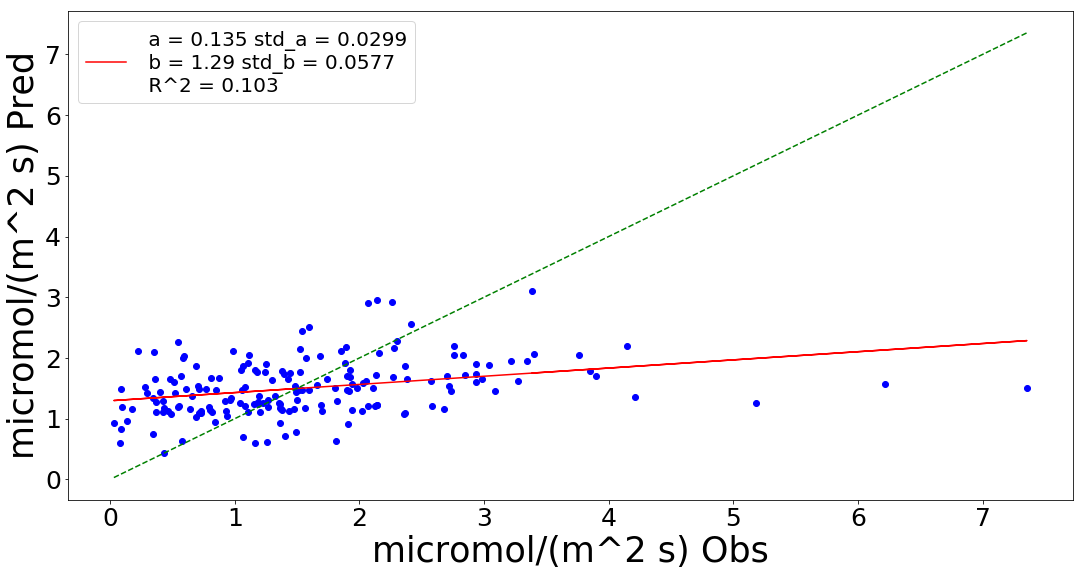

In [79]:
mod_1_p4, comp_1_p4 = analisis(respiracion_1,
                               muestra_p4['Tair'].add(273.15),
                               muestra_p4['NEE'],
                               validacion_p4['Tair'].add(273.15),
                               validacion_p4['NEE'],
                               'K', 'micromol/(m^2 s)')

MBE 0.0122
MAE 0.939
MSE 1.42
RMSE 1.19
Indice de acuerdo 0.951



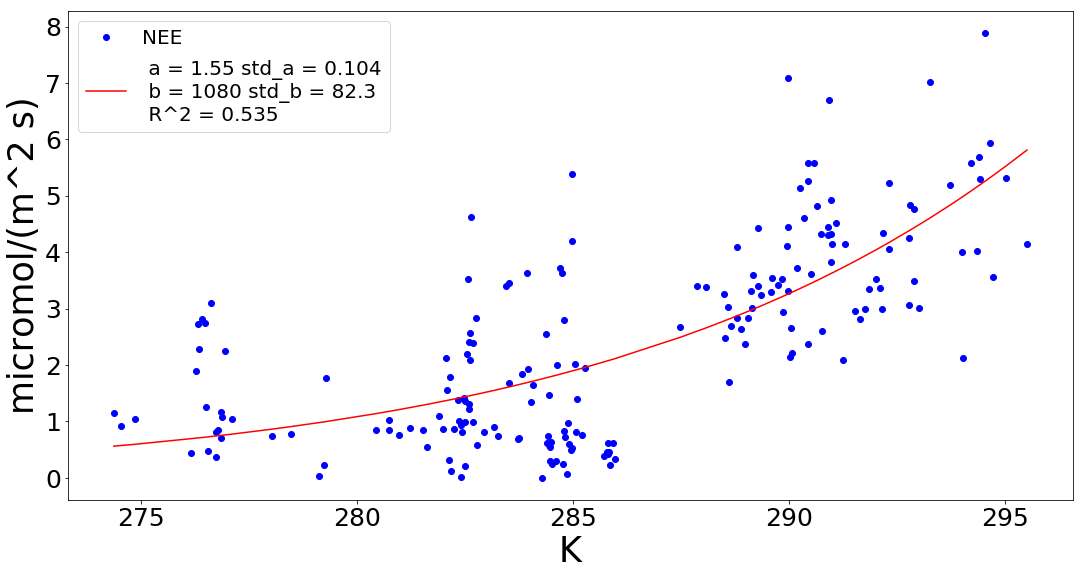

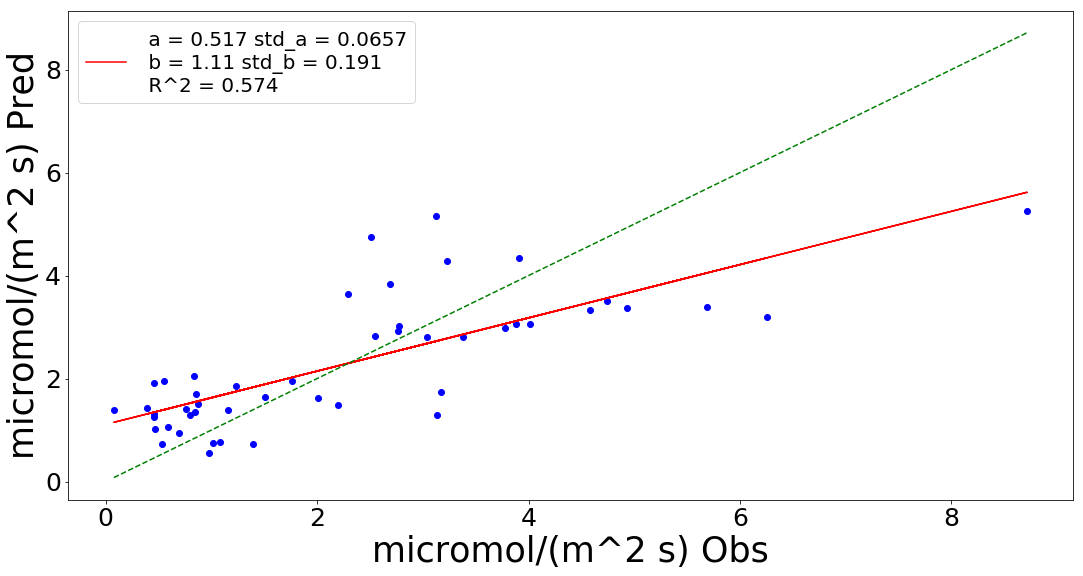

In [83]:
mod_2_p2, comp_2_p2 = analisis(respiracion_2,
                               muestra_p2['Tair'].add(273.15),
                               muestra_p2['NEE'],
                               validacion_p2['Tair'].add(273.15),
                               validacion_p2['NEE'],
                               'K', 'micromol/(m^2 s)')

MBE 0.00729
MAE 0.457
MSE 0.327
RMSE 0.572
Indice de acuerdo 0.906



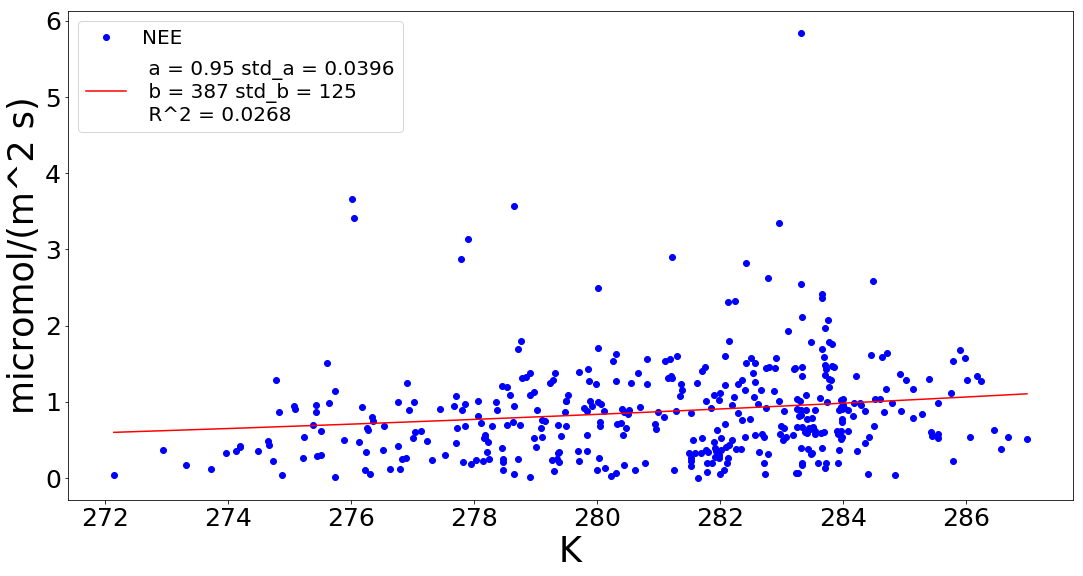

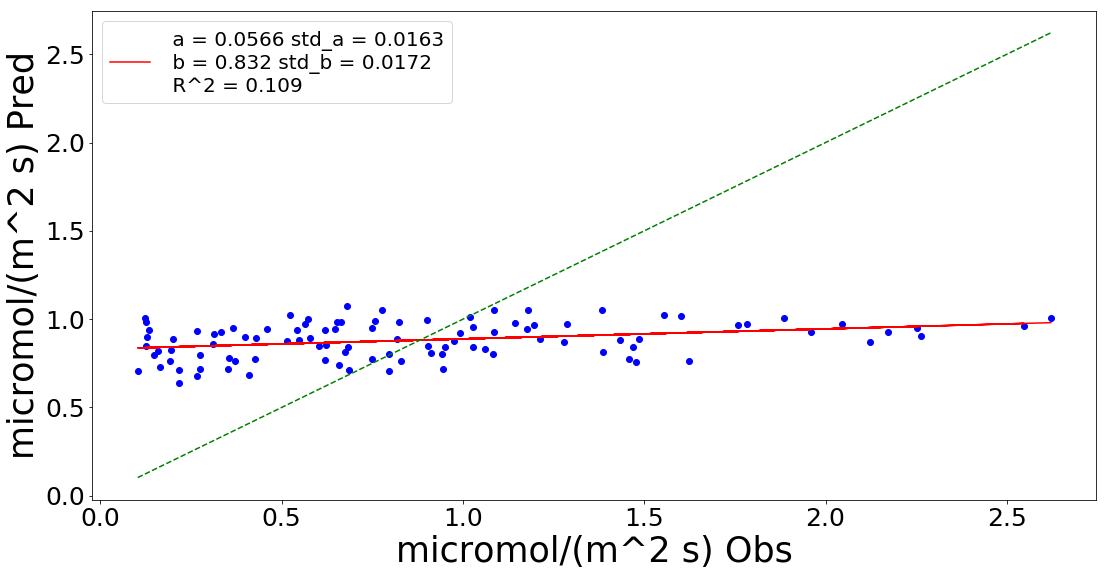

In [84]:
mod_2_p3, comp_2_p3 = analisis(respiracion_2,
                               muestra_p3['Tair'].add(273.15),
                               muestra_p3['NEE'],
                               validacion_p3['Tair'].add(273.15),
                               validacion_p3['NEE'],
                               'K', 'micromol/(m^2 s)')

MBE -0.0735
MAE 0.748
MSE 1.1
RMSE 1.05
Indice de acuerdo 0.902



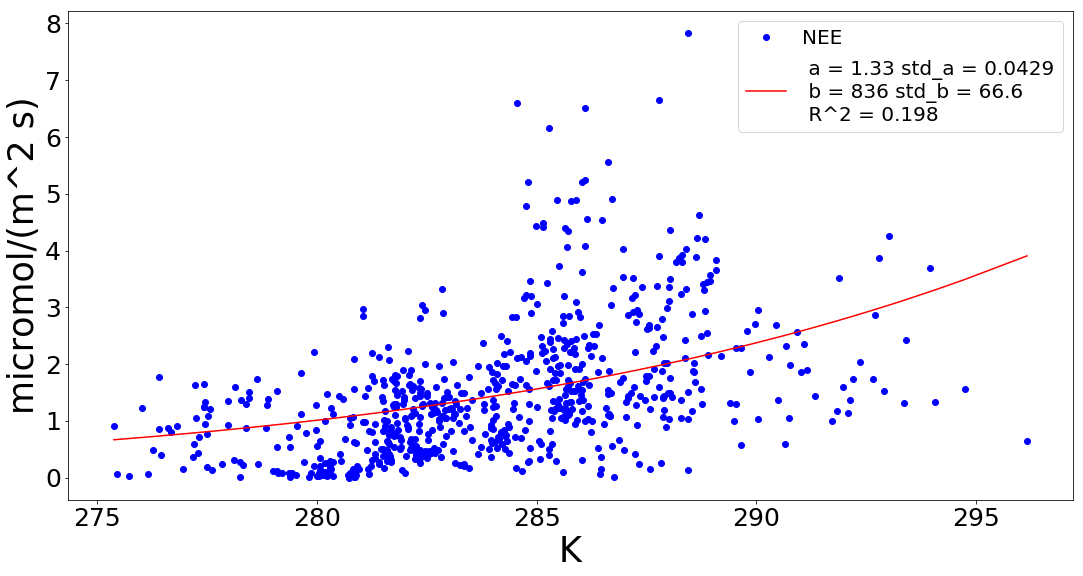

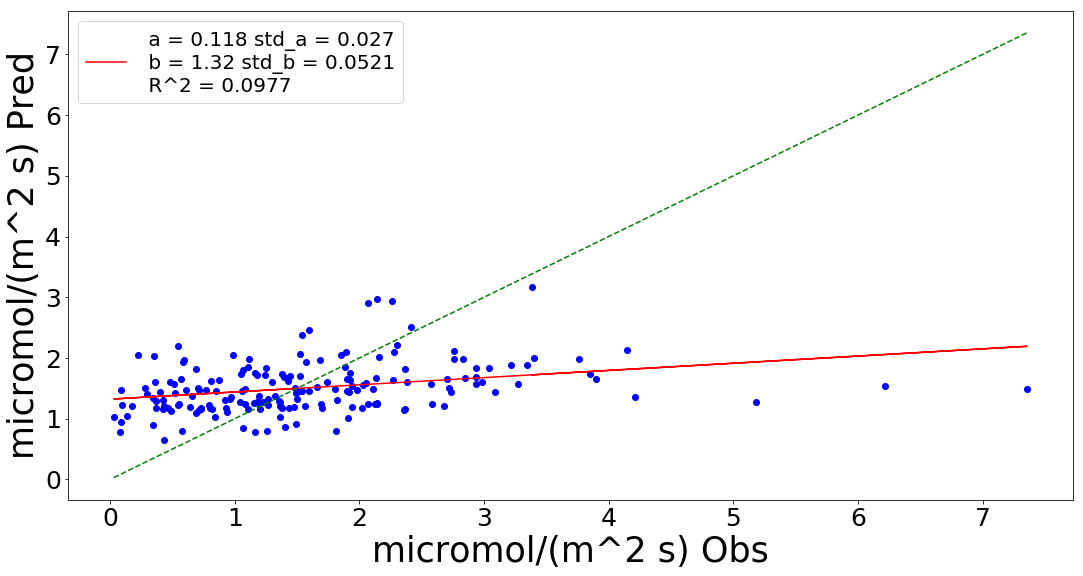

In [85]:
mod_2_p4, comp_2_p4 = analisis(respiracion_2,
                               muestra_p4['Tair'].add(273.15),
                               muestra_p4['NEE'],
                               validacion_p4['Tair'].add(273.15),
                               validacion_p4['NEE'],
                               'K', 'micromol/(m^2 s)')